In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT

In [32]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

function hist_1d(smpls, dim_1; nbins=40)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    hist_tmp = fit(Histogram, smpl_tmp[dim_1,:], FrequencyWeights(smpl_w), nbins=nbins)
    hist_tmp = normalize(hist_tmp, mode=:pdf)
    return hist_tmp
end

hist_1d (generic function with 1 method)

In [3]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058

prior_41 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.02, 0.16), truncated(Normal(0.2, 0.04), 0.02, 0.16)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.02, 0.16), truncated(Normal(0.2, 0.04), 0.02, 0.16)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 8.5), truncated(Normal(4.0, 2.0), 4.0, 8.5)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0, # 20
        cam4_light_fluct =  1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

prior_35 = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.02, 0.20), truncated(Normal(0.2, 0.04), 0.02, 0.20)],
    ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
    waist = [Normal(2.9, 0.03)],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0, # 14
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

In [5]:
smpl_35 = bat_read("../../data/sampling_results/Benchmark-8/samples-35.hdf5")
smpl_35 = varshape(prior_35).(smpl_35);

In [6]:
smpl_41 = bat_read("../../data/sampling_results/Benchmark-8/samples-41.hdf5")
smpl_41 = varshape(prior_41).(smpl_41);

In [8]:
mode_35 = mode(smpl_35)
mode_41 = mode(smpl_41);

In [33]:
hist_35_12 = hist_2d(smpl_35, 1,2);
hist_35_34 = hist_2d(smpl_35, 3,4);
hist_35_1 = hist_1d(smpl_35, 5);

In [38]:
hist_41_12 = hist_2d(smpl_41, 1,2);
hist_41_34 = hist_2d(smpl_41, 3,4);
hist_41_56 = hist_2d(smpl_41, 5,6);
hist_41_78 = hist_2d(smpl_41, 7,8);
hist_41_10 = hist_1d(smpl_41, 10);
hist_41_11 = hist_1d(smpl_41, 11);

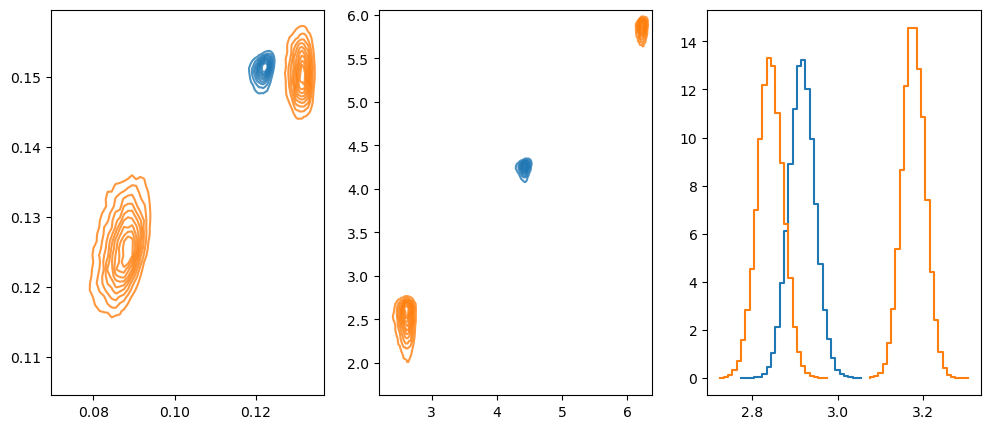

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f749b416880>

In [43]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1].contour(midpoints(hist_35_11.edges[1]), midpoints(hist_35_11.edges[2]), hist_35_11.weights', 
    levels=range(minimum(hist_35_11.weights'), maximum(hist_35_11.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_35_34.edges[1]), midpoints(hist_35_34.edges[2]), hist_35_34.weights', 
    levels=range(minimum(hist_35_34.weights'), maximum(hist_35_34.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[3].step(midpoints(hist_35_1.edges[1]), hist_35_1.weights, color="C0")

ax[1].contour(midpoints(hist_41_12.edges[1]), midpoints(hist_41_12.edges[2]), hist_41_12.weights', 
    levels=range(minimum(hist_41_12.weights'), maximum(hist_41_12.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[1].contour(midpoints(hist_41_34.edges[1]), midpoints(hist_41_34.edges[2]), hist_41_34.weights', 
    levels=range(minimum(hist_41_34.weights'), maximum(hist_41_34.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_56.edges[1]), midpoints(hist_41_56.edges[2]), hist_41_56.weights', 
    levels=range(minimum(hist_41_56.weights'), maximum(hist_41_56.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_78.edges[1]), midpoints(hist_41_78.edges[2]), hist_41_78.weights', 
    levels=range(minimum(hist_41_78.weights'), maximum(hist_41_78.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[3].step(midpoints(hist_41_10.edges[1]), hist_41_10.weights, color="C1")

ax[3].step(midpoints(hist_41_11.edges[1]), hist_41_11.weights, color="C1")

In [44]:
hist_35_1 = hist_2d(smpl_35, 17,20)
hist_35_2 = hist_2d(smpl_35, 18,21)
hist_35_3 = hist_2d(smpl_35, 18,22)
hist_35_4 = hist_2d(smpl_35, 23,24);

In [46]:
hist_41_1 = hist_2d(smpl_41, 23,26)
hist_41_2 = hist_2d(smpl_41, 24,27)
hist_41_3 = hist_2d(smpl_41, 25,28)
hist_41_4 = hist_2d(smpl_41, 29,30);

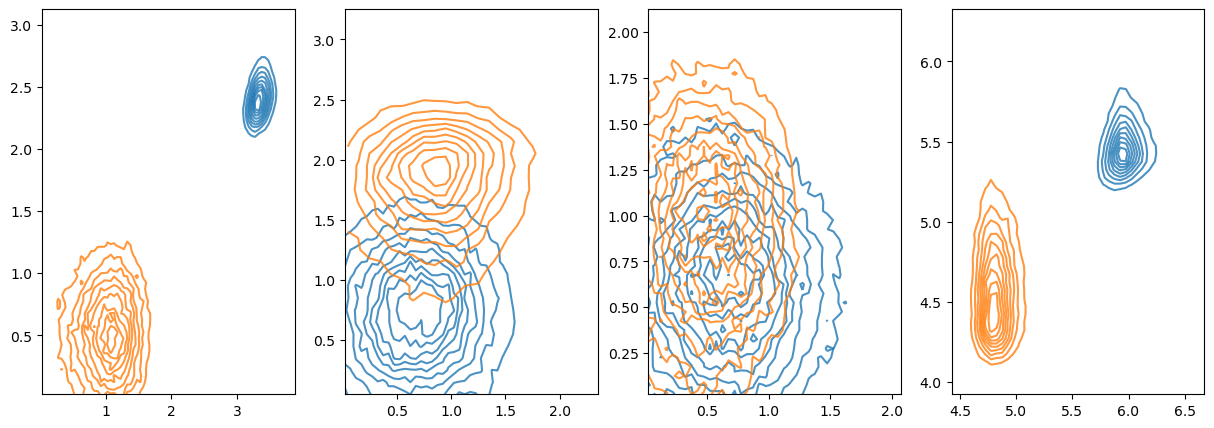

PyObject <matplotlib.contour.QuadContourSet object at 0x7f74866873d0>

In [53]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1].contour(midpoints(hist_35_1.edges[1]), midpoints(hist_35_1.edges[2]), hist_35_1.weights', 
    levels=range(minimum(hist_35_1.weights'), maximum(hist_35_1.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[1].contour(midpoints(hist_41_1.edges[1]), midpoints(hist_41_1.edges[2]), hist_41_1.weights', 
    levels=range(minimum(hist_41_1.weights'), maximum(hist_41_1.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_35_2.edges[1]), midpoints(hist_35_2.edges[2]), hist_35_2.weights', 
    levels=range(minimum(hist_35_2.weights'), maximum(hist_35_2.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_2.edges[1]), midpoints(hist_41_2.edges[2]), hist_41_2.weights', 
    levels=range(minimum(hist_41_2.weights'), maximum(hist_41_2.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 


ax[3].contour(midpoints(hist_35_3.edges[1]), midpoints(hist_35_3.edges[2]), hist_35_3.weights', 
    levels=range(minimum(hist_35_3.weights'), maximum(hist_35_3.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[3].contour(midpoints(hist_41_3.edges[1]), midpoints(hist_41_3.edges[2]), hist_41_3.weights', 
    levels=range(minimum(hist_41_3.weights'), maximum(hist_41_3.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[4].contour(midpoints(hist_35_4.edges[1]), midpoints(hist_35_4.edges[2]), hist_35_4.weights', 
    levels=range(minimum(hist_35_4.weights'), maximum(hist_35_4.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[4].contour(midpoints(hist_41_4.edges[1]), midpoints(hist_41_4.edges[2]), hist_41_4.weights', 
    levels=range(minimum(hist_41_4.weights'), maximum(hist_41_4.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 


In [66]:
function rad(sgm, sigmap, waist)
    return f(x) = sqrt.(sgm^2 + 10^-4*sigmap^2*(waist - x)^2)
end

rad (generic function with 1 method)

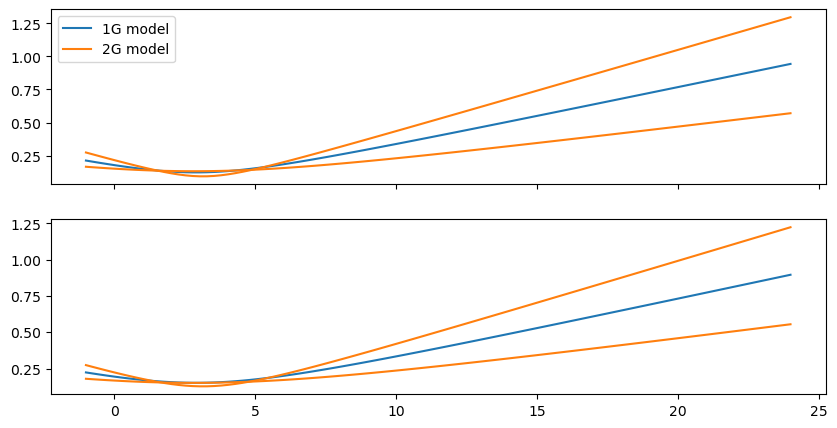

PyObject <matplotlib.legend.Legend object at 0x7f7485a202b0>

In [81]:
x_range = range(-1, stop = 24, length=100)

fig, (ax, ax2)= plt.subplots(2,1, figsize=(10,5), sharex=true)

ax.plot(x_range, rad(mode_35.tr_size[1], mode_35.ang_spr[1], mode_35.waist[1]).(x_range), color="C0", label="1G model")
ax.plot(x_range, rad(mode_41.tr_size[1], mode_41.ang_spr[1], mode_41.waist[1]).(x_range), color="C1", label="2G model")
ax.plot(x_range, rad(mode_41.tr_size_2[1], mode_41.ang_spr_2[1], mode_41.waist_2[1]).(x_range), color="C1")


ax2.plot(x_range, rad(mode_35.tr_size[2], mode_35.ang_spr[2], mode_35.waist[1]).(x_range), color="C0")
ax2.plot(x_range, rad(mode_41.tr_size[2], mode_41.ang_spr[2], mode_41.waist[1]).(x_range), color="C1")
ax2.plot(x_range, rad(mode_41.tr_size_2[2], mode_41.ang_spr_2[2], mode_41.waist_2[1]).(x_range), color="C1")

ax.legend()